In [1]:
import pandas as pd
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from scipy.stats import multivariate_normal as mv_normal
from sklearn.cluster import KMeans
import math

In [2]:
data = pd.read_csv("fashion-mnist_train.csv")
data_test = pd.read_csv("fashion-mnist_test.csv")

In [3]:
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y = data['label'].to_numpy()

In [5]:
y

array([2, 9, 6, ..., 8, 8, 7], dtype=int64)

In [6]:
df = data.drop(columns=['label'])
df_test = data_test.drop(columns=['label'])

In [7]:
X = df.to_numpy()
X_test = df_test.to_numpy()

(60000, 784)

(60000,)

(10000, 784)

In [22]:

class Cluster:
    def __init__ (self,mu,sigma,pi):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma
        
    def summary(self):
        print(self.pi)
        print(self.mu.shape)
        print(self.sigma.shape)
        
        


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def logsumexp(x):
    e_x = np.exp(x - np.max(x))
    return np.max(x) + e_x.sum()

class GMM:
    def __init__(self,X,numclusters):
        self.numclusters = numclusters
        self.X = X
        self.gamma = np.zeros((X.shape[0],numclusters), dtype=np.float64)
    
        self.clusters = []
        kmeans = KMeans(self.numclusters).fit(self.X)
        means = kmeans.cluster_centers_
        
        for i in range(self.numclusters):
            mu = means[i]
            sigma = np.identity(self.X.shape[1])
            self.clusters.append(Cluster(mu,sigma,1.0/self.numclusters))
    
    
    def E_step(self):
        for k,cluster in enumerate(self.clusters):
            gaussian = mv_normal(mean=cluster.mu, cov=cluster.sigma)
            self.gamma[:,k] = np.log(cluster.pi) + gaussian.logpdf(X)
        
        for i in range(self.X.shape[0]):
            self.gamma[i,:] = softmax(self.gamma[i,:])
        
        
    

    def M_step(self):
        
        N = self.X.shape[0]
        
        for k in range(len(self.clusters)):
            
            gamma_k = np.expand_dims(self.gamma[:,k],1)
            N_k = np.sum(gamma_k,axis=0)
            pi_k = N_k/N
            mu_k = np.sum(gamma_k*X,axis=0)/N_k
            #sigma_k = (gamma_k * (X - self.clusters[k].mu)).T @ (X - self.clusters[k].mu) / N_k 
            sigma_k = np.sum(gamma_k*(X - self.clusters[k].mu)**2) / (N_k*self.X.shape[1]) 
            self.clusters[k].mu = mu_k
            self.clusters[k].sigma = sigma_k*np.identity(self.X.shape[1])
            self.clusters[k].pi = pi_k
            
    def cross_entropy(self,X):
        
        gamma = np.zeros((X.shape[0],len(self.clusters)), dtype=np.float64)
        
        for k,cluster in enumerate(self.clusters):
            gaussian = mv_normal(mean=cluster.mu, cov=cluster.sigma)
            gamma[:,k] = np.log(cluster.pi) + gaussian.logpdf(X)
        
        return -np.sum(logsumexp(gamma), axis=0)/X.shape[0]
        
    def generate_samples(self,numsamples):
        
        latent_prob = np.array([x.pi for x in self.clusters]).T[0]
        Z = np.random.choice(list(range(self.numclusters)), numsamples, p=latent_prob)
        X = []
        for z in Z:
            X.append(np.random.multivariate_normal(self.clusters[z].mu, self.clusters[z].sigma, 1)[0])
        
        return np.array(X),Z
            
            

model = GMM(X,10)
max_iterations = 5
print("iter : {0}, train_cross_entropy : {1}, test_cross_entropy : {2}".format(0,model.cross_entropy(X),model.cross_entropy(X_test)))
for i in range(max_iterations):
    model.E_step()
    model.M_step()
    print("iter : {0}, train_cross_entropy : {1}, test_cross_entropy : {2}".format(i+1,model.cross_entropy(X),model.cross_entropy(X_test)))

X_gen,Z_gen = model.generate_samples(100)

    
    

iter : 0, train_cross_entropy : 3.5530118807197137, test_cross_entropy : 23.327614548851976
iter : 1, train_cross_entropy : 0.06384801066461475, test_cross_entropy : 0.3837780783611193
iter : 2, train_cross_entropy : 0.06353296392154721, test_cross_entropy : 0.38227170203224164
iter : 3, train_cross_entropy : 0.06335217514613598, test_cross_entropy : 0.38152699861444994
iter : 4, train_cross_entropy : 0.06324185465086134, test_cross_entropy : 0.3811215585196985
iter : 5, train_cross_entropy : 0.06319001479974864, test_cross_entropy : 0.3809418685380619


mu

In [26]:
# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])
     

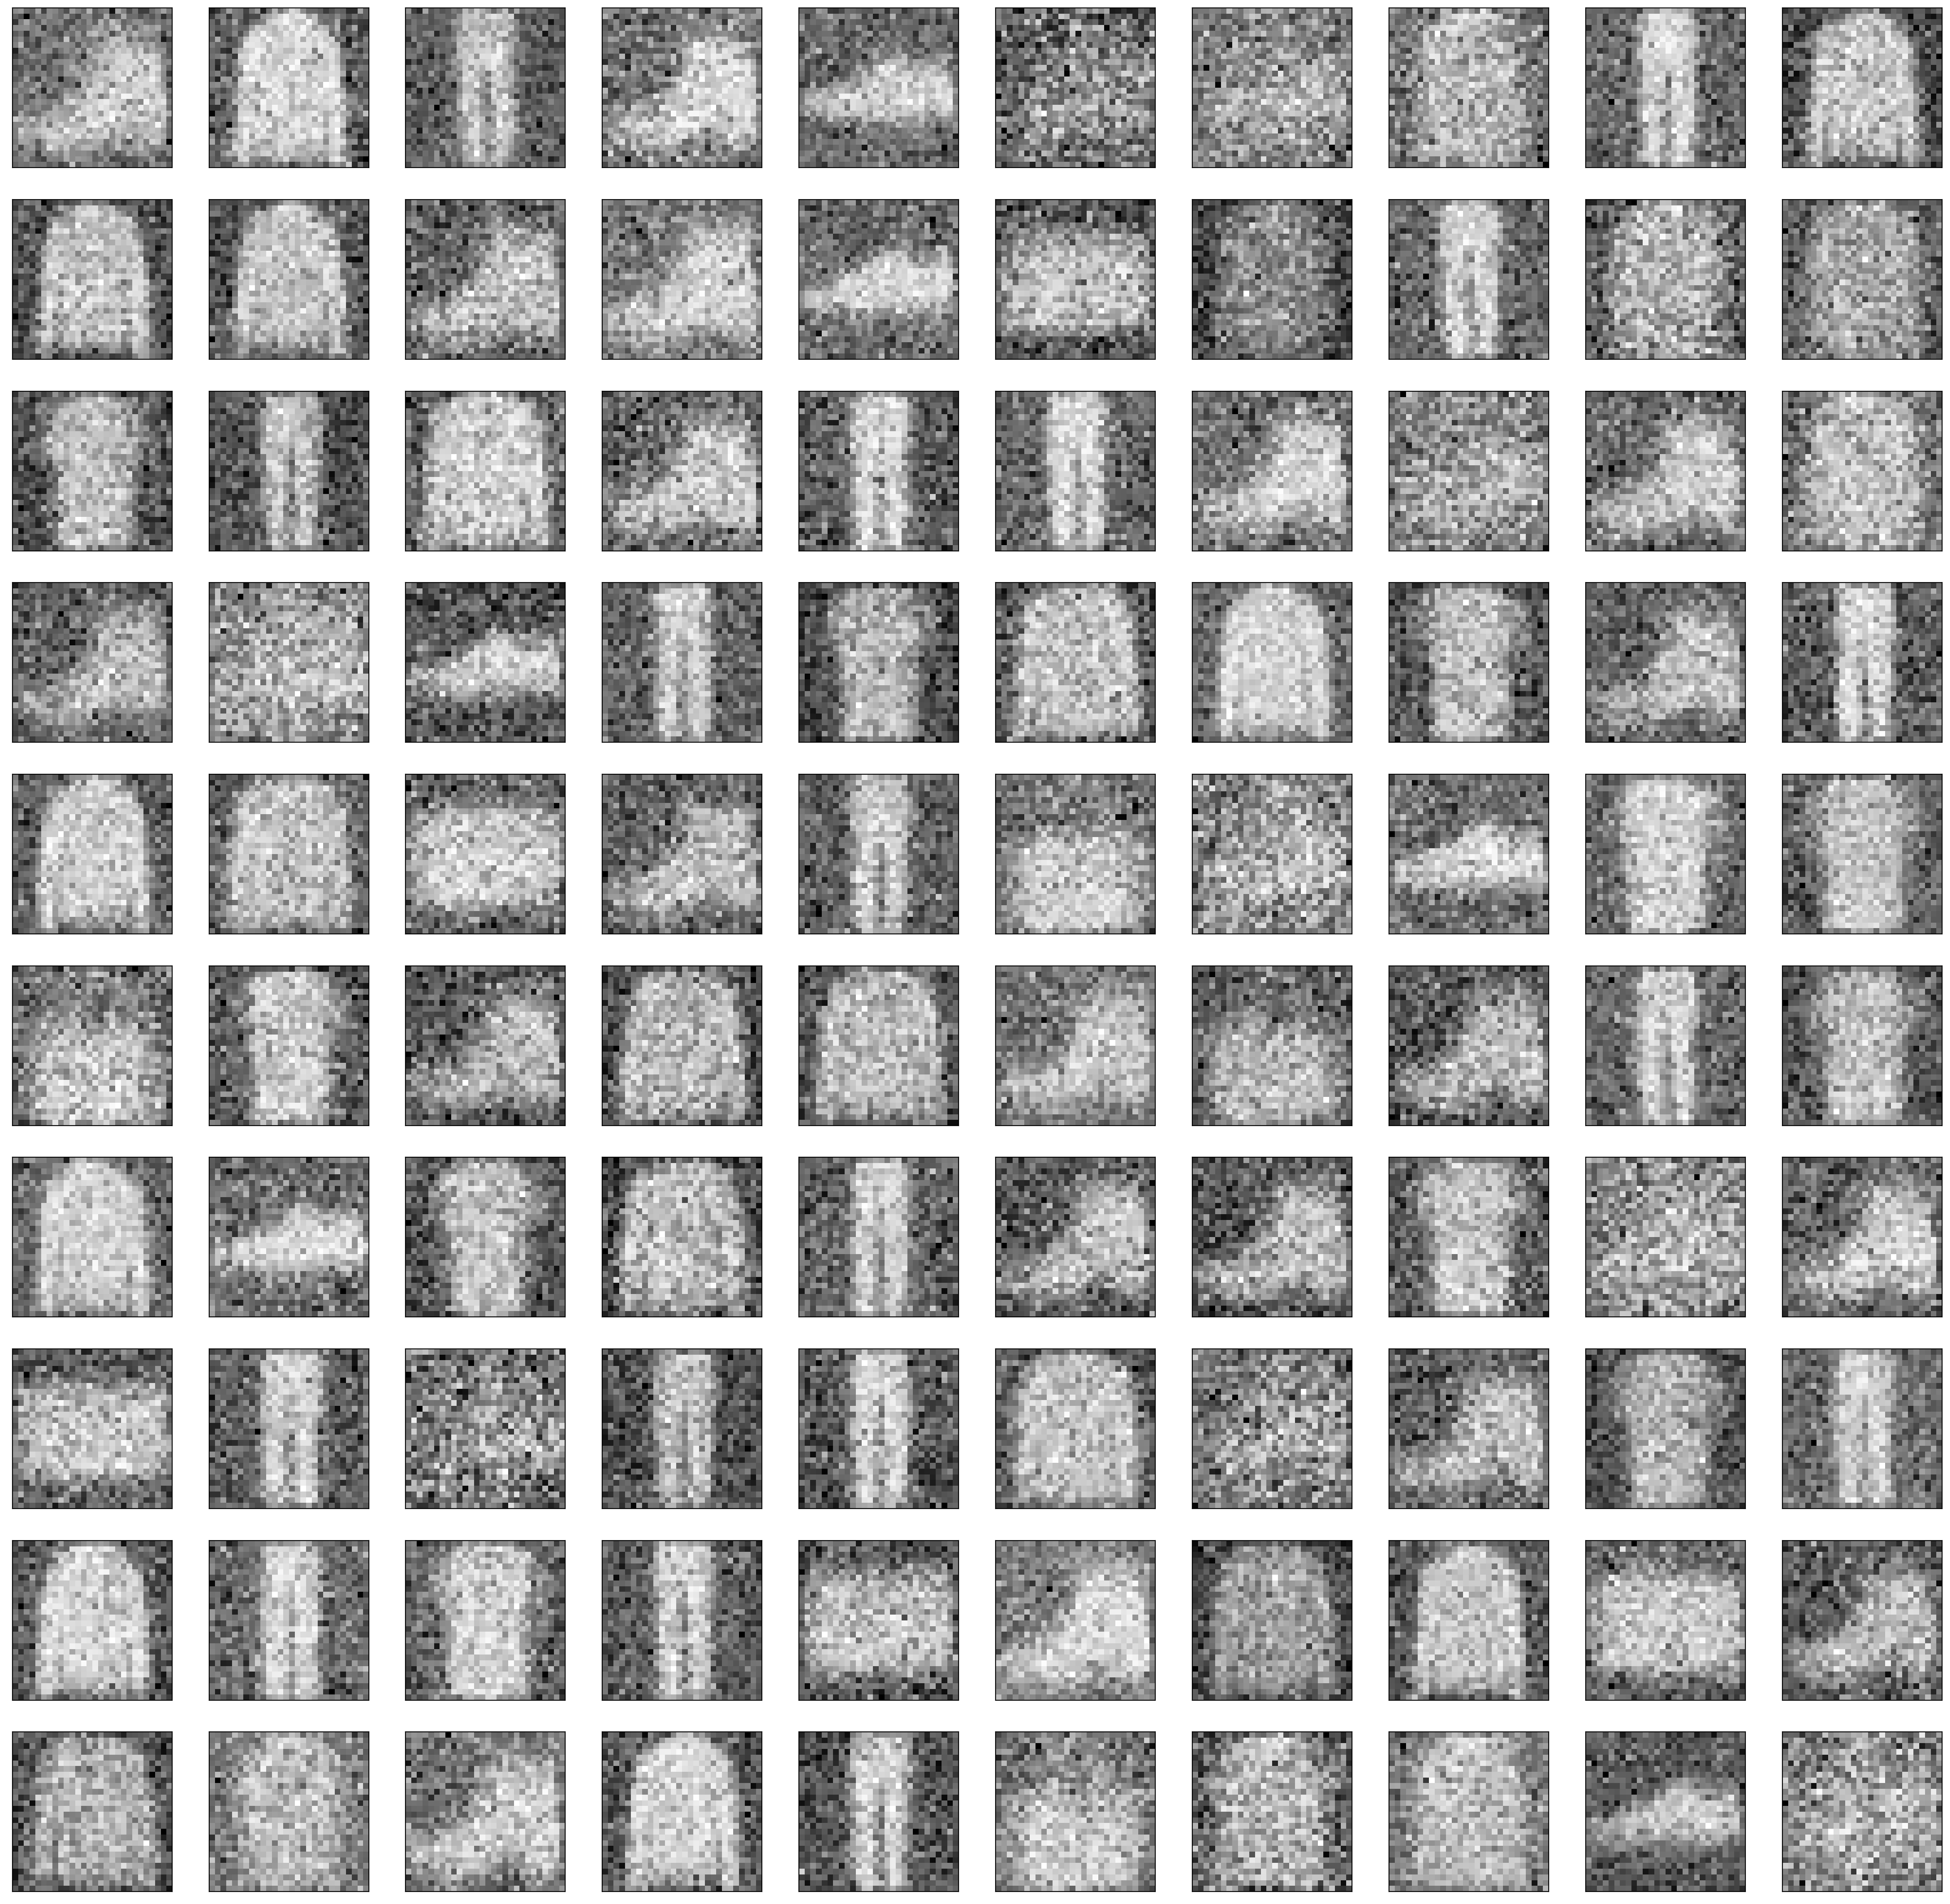

In [34]:

show_images_grid(np.reshape(X_gen,(-1,28,28)),100)